In [10]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pyswarms as ps
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.preprocessing import StandardScaler
import time

## Data

In [11]:
image = np.load("data/cropclustering/salinas_image.npy")
labels = np.load("data/cropclustering/salinas_labels.npy")

crop_type = ["Undefined", "Brocoli_green_weeds_1", "Brocoli_green_weeds_2", "Fallow","Fallow_rough_plow", "Fallow_smooth", "Stubble","Celery", "Grapes_untrained","Soil_vinyard_develop","Corn_senesced_green_weeds","Lettuce_romaine_4wk", "Lettuce_romaine_5wk",
        "Lettuce_romaine_6wk", "Lettuce_romaine_7wk", "Vinyard_untrained", "Vinyard_vertical_trellis"]

## Exploration

### RGB image

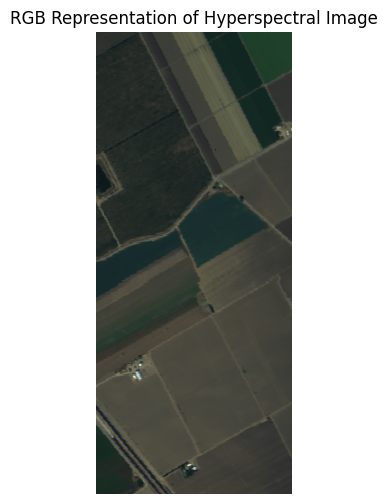

In [3]:
# Select the apporpriate bands for the RGB approximation
rgb_image = image[:, :, [29, 19, 9]]  

# Normalize the image for display
rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(rgb_image)
plt.title("RGB Representation of Hyperspectral Image")
plt.axis("off")
plt.show()

### Other non-RGB spectral bands

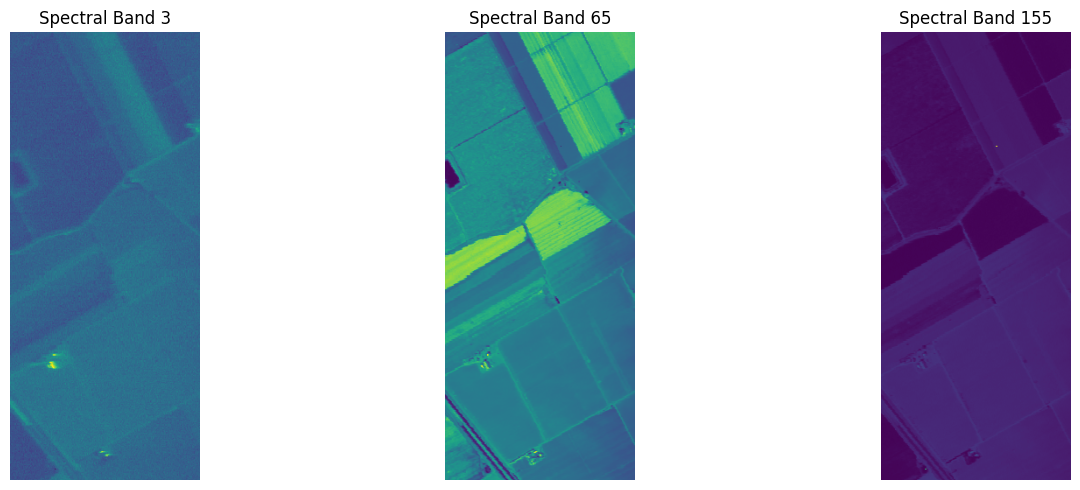

In [4]:
channel3 = image[:, :, 2]    # 3rd spectral band
channel65 = image[:, :, 64]  # 65th spectral band
channel155 = image[:, :, 154] # 155th spectral band

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot each channel with a title
axes[0].imshow(channel3)
axes[0].set_title("Spectral Band 3")

axes[1].imshow(channel65)
axes[1].set_title("Spectral Band 65")

axes[2].imshow(channel155)
axes[2].set_title("Spectral Band 155")

# Remove axis ticks
for ax in axes:
    ax.axis("off")

# Show the plots
plt.tight_layout()
plt.show()

### Labels

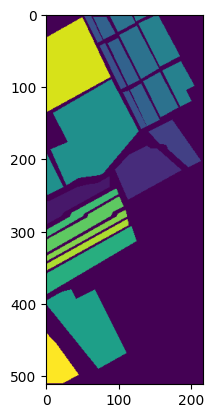

In [5]:
plt.imshow(labels)

### Some statistics

In [6]:
# Get image dimensions and spectral bands
height, width, spectral_bands = image.shape
print(f"Image Dimensions: {height} x {width}")
print(f"Number of Spectral Bands: {spectral_bands}\n")

# Unique crop categories
unique_labels = np.unique(labels)
num_classes = len(unique_labels)
print(f"Total Unique Crop Types: {num_classes}")

# Count the number of pixels per crop type
pixel_counts = np.bincount(labels.ravel())

# Display pixel distribution per crop type
print("\nPixel Count per Crop Type:")
unique, counts = np.unique(labels, return_counts = True)
for i, count in enumerate(pixel_counts):
    print(f"{crop_type[unique[i]]}: {count} pixels")

Image Dimensions: 512 x 217
Number of Spectral Bands: 204

Total Unique Crop Types: 17

Pixel Count per Crop Type:
Undefined: 56975 pixels
Brocoli_green_weeds_1: 2009 pixels
Brocoli_green_weeds_2: 3726 pixels
Fallow: 1976 pixels
Fallow_rough_plow: 1394 pixels
Fallow_smooth: 2678 pixels
Stubble: 3959 pixels
Celery: 3579 pixels
Grapes_untrained: 11271 pixels
Soil_vinyard_develop: 6203 pixels
Corn_senesced_green_weeds: 3278 pixels
Lettuce_romaine_4wk: 1068 pixels
Lettuce_romaine_5wk: 1927 pixels
Lettuce_romaine_6wk: 916 pixels
Lettuce_romaine_7wk: 1070 pixels
Vinyard_untrained: 7268 pixels
Vinyard_vertical_trellis: 1807 pixels


## Preprocessing

### Restructuring

In [31]:
# Reshape the hyperspectral image and labels
reshaped_image = image.reshape(-1, image.shape[-1], order='C')
reshaped_labels = labels.ravel(order='C')

# Remove "Undefined" category (label 0)
valid_indices = reshaped_labels != 0
clean_image = reshaped_image[valid_indices]
clean_labels = reshaped_labels[valid_indices]

### Dimensionality reduction

In [ ]:
scaled = StandardScaler().fit_transform(clean_image)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_crops = tsne.fit_transform(scaled)
labels = clean_labels.reshape(-1, 1)  
tsne_crops = np.hstack((labels, tsne_crops))
np.save('data/cropclustering/tsne_crops.npy', tsne_crops)

c:\Users\seppe\OneDrive\Desktop\Cursussen\Big Data Algorithms\Project\BDA-project\.env\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


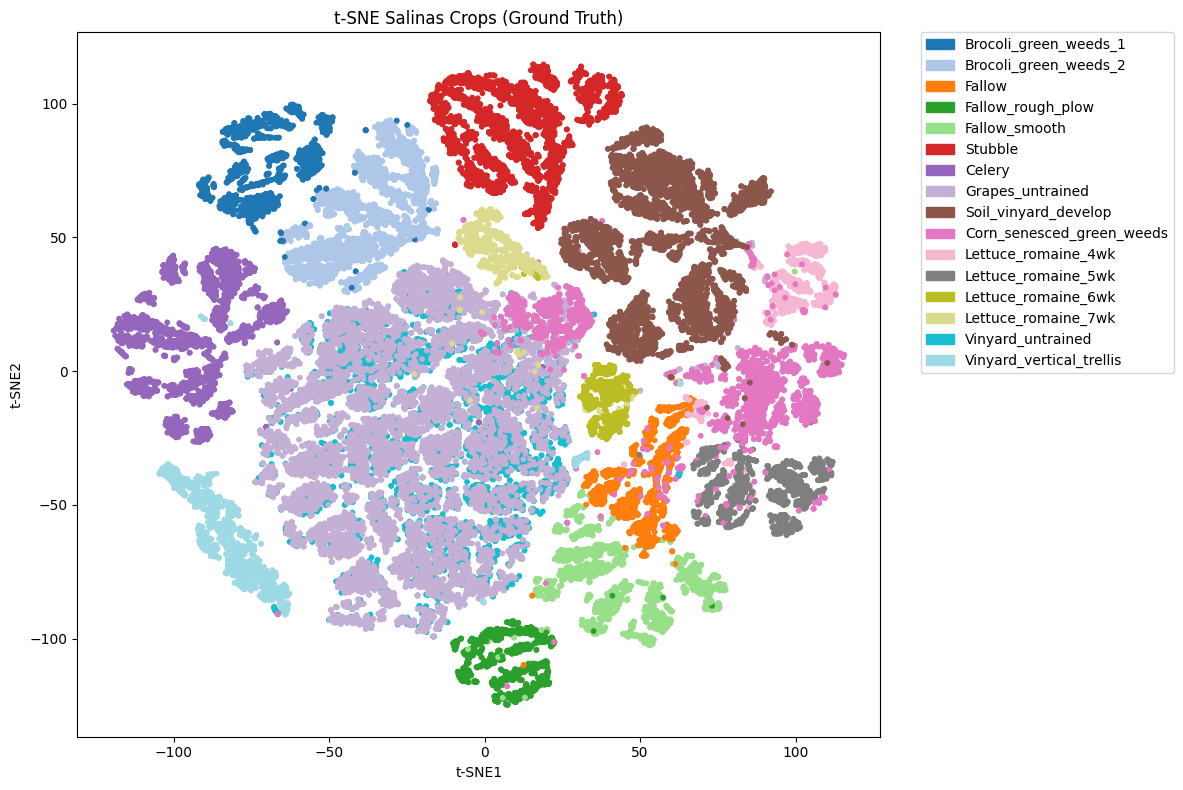

In [12]:
tsne_crops = np.load("data/cropclustering/tsne_crops.npy")
plt.figure(figsize=(12, 8))
scatter = plt.scatter(tsne_crops[:, 1], tsne_crops[:, 2], c=tsne_crops[:, 0], cmap='tab20', s=10)
plt.title('t-SNE Salinas Crops (Ground Truth)')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')

handles = [mpatches.Patch(color=scatter.cmap(scatter.norm(i)), label=crop_type[i]) for i in range(1, len(crop_type))]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

## Functions

In [13]:
def clustering_objective_function(particles, data, n_clusters):
    """
    For each candidate solution (particle), compute the sum of squared distances
    of each data point to its nearest cluster center.
    Each particle is a flattened array of cluster centers.
    """
    n_particles = particles.shape[0]
    n_features = data.shape[1]
    cost = np.zeros(n_particles)
    
    for i in range(n_particles):
        centers = particles[i].reshape((n_clusters, n_features))
        distances = pairwise_distances(data, centers, metric='euclidean')
        min_distances = np.min(distances, axis=1)
        cost[i] = np.sum(min_distances**2)
    return cost

def run_pso(data_tsne, n_clusters, iters=100, n_particles=30, options={'c1': 1.5, 'c2': 1.5, 'w': 0.7}):
    n_features = data_tsne.shape[1]  # 2 for t-SNE
    dimensions = n_clusters * n_features
    # Define bounds based on t-SNE data range
    lb = np.min(data_tsne) * np.ones(dimensions)
    ub = np.max(data_tsne) * np.ones(dimensions)
    bounds = (lb, ub)
    
    optimizer = ps.single.GlobalBestPSO(n_particles=n_particles, dimensions=dimensions,
                                        options=options, bounds=bounds)
    best_cost, best_pos = optimizer.optimize(clustering_objective_function,
                                             iters=iters,
                                             data=data_tsne,
                                             n_clusters=n_clusters,
                                             verbose=False)
    best_centers = best_pos.reshape((n_clusters, n_features))
    distances = cdist(data_tsne, best_centers, metric='euclidean')
    labels = np.argmin(distances, axis=1)
    sil_score = silhouette_score(data_tsne, labels)
    return best_cost, best_centers, labels, sil_score

def run_abc(data_tsne, n_clusters, iters=100, n_food_sources=30, limit=20):
    n_features = data_tsne.shape[1]
    dimensions = n_clusters * n_features
    lb = np.min(data_tsne) * np.ones(dimensions)
    ub = np.max(data_tsne) * np.ones(dimensions)
    
    # Initialize food sources randomly
    food_sources = np.random.uniform(low=lb, high=ub, size=(n_food_sources, dimensions))
    fitness = clustering_objective_function(food_sources, data_tsne, n_clusters)
    trial_counters = np.zeros(n_food_sources)
    
    best_index = np.argmin(fitness)
    best_solution = food_sources[best_index].copy()
    best_cost = fitness[best_index]
    
    for t in range(iters):
        # Employed bees phase
        for i in range(n_food_sources):
            # Select a random partner (different from i)
            j = np.random.randint(0, n_food_sources)
            while j == i:
                j = np.random.randint(0, n_food_sources)
            phi = np.random.uniform(-1, 1, size=dimensions)
            candidate = food_sources[i] + phi * (food_sources[i] - food_sources[j])
            candidate = np.clip(candidate, lb, ub)
            candidate_fitness = clustering_objective_function(candidate[np.newaxis, :], data_tsne, n_clusters)[0]
            if candidate_fitness < fitness[i]:
                food_sources[i] = candidate
                fitness[i] = candidate_fitness
                trial_counters[i] = 0
            else:
                trial_counters[i] += 1
        
        # Onlooker bees phase
        prob = (1.0 / (fitness + 1e-10))
        prob = prob / np.sum(prob)
        for i in range(n_food_sources):
            if np.random.rand() < prob[i]:
                j = np.random.randint(0, n_food_sources)
                while j == i:
                    j = np.random.randint(0, n_food_sources)
                phi = np.random.uniform(-1, 1, size=dimensions)
                candidate = food_sources[i] + phi * (food_sources[i] - food_sources[j])
                candidate = np.clip(candidate, lb, ub)
                candidate_fitness = clustering_objective_function(candidate[np.newaxis, :], data_tsne, n_clusters)[0]
                if candidate_fitness < fitness[i]:
                    food_sources[i] = candidate
                    fitness[i] = candidate_fitness
                    trial_counters[i] = 0
                else:
                    trial_counters[i] += 1
        
        # Scout phase: Reinitialize sources that haven't improved
        for i in range(n_food_sources):
            if trial_counters[i] > limit:
                food_sources[i] = np.random.uniform(low=lb, high=ub, size=dimensions)
                fitness[i] = clustering_objective_function(food_sources[i][np.newaxis, :], data_tsne, n_clusters)[0]
                trial_counters[i] = 0
        
        # Update best solution
        current_best_index = np.argmin(fitness)
        if fitness[current_best_index] < best_cost:
            best_cost = fitness[current_best_index]
            best_solution = food_sources[current_best_index].copy()
    
    best_centers = best_solution.reshape((n_clusters, n_features))
    distances = cdist(data_tsne, best_centers, metric='euclidean')
    labels = np.argmin(distances, axis=1)
    sil_score = silhouette_score(data_tsne, labels)
    return best_cost, best_centers, labels, sil_score

def run_acor(data_tsne, n_clusters, iters=100, archive_size=30, ants=30, q=0.5, xi=0.85):
    """
    ACOR: An Ant Colony Optimization algorithm adapted for continuous optimization.
    It maintains an archive of solutions and generates new solutions by Gaussian sampling.
    """
    n_features = data_tsne.shape[1]
    dimensions = n_clusters * n_features
    lb = np.min(data_tsne) * np.ones(dimensions)
    ub = np.max(data_tsne) * np.ones(dimensions)
    
    # Initialize archive with random solutions
    archive = np.random.uniform(low=lb, high=ub, size=(archive_size, dimensions))
    fitness = clustering_objective_function(archive, data_tsne, n_clusters)
    
    for t in range(iters):
        # Sort archive (best fitness first)
        sorted_idx = np.argsort(fitness)
        archive = archive[sorted_idx]
        fitness = fitness[sorted_idx]
        
        # Compute weights (Gaussian kernel based on rank)
        ranks = np.arange(archive_size)
        weights = (1 / (q * archive_size * np.sqrt(2 * np.pi))) * \
                  np.exp(- (ranks ** 2) / (2 * (q * archive_size) ** 2))
        weights = weights / np.sum(weights)
        
        # Compute standard deviations for Gaussian sampling
        sigma = np.zeros((archive_size, dimensions))
        for i in range(archive_size):
            diff = archive - archive[i]
            sigma[i] = xi * np.std(diff, axis=0)
            sigma[i][sigma[i] == 0] = 1e-6  # Prevent zero std
        
        # Generate new candidate solutions
        new_solutions = np.zeros((ants, dimensions))
        for i in range(ants):
            # Select a solution from archive using weighted probability
            idx = np.random.choice(np.arange(archive_size), p=weights)
            new_solution = np.random.normal(loc=archive[idx], scale=sigma[idx])
            new_solution = np.clip(new_solution, lb, ub)
            new_solutions[i] = new_solution
        
        new_fitness = clustering_objective_function(new_solutions, data_tsne, n_clusters)
        
        # Merge archive and new solutions, then keep the best 'archive_size' solutions
        combined = np.vstack((archive, new_solutions))
        combined_fitness = np.concatenate((fitness, new_fitness))
        sorted_idx = np.argsort(combined_fitness)
        archive = combined[sorted_idx][:archive_size]
        fitness = combined_fitness[sorted_idx][:archive_size]
    
    best_solution = archive[0]
    best_cost = fitness[0]
    best_centers = best_solution.reshape((n_clusters, n_features))
    distances = cdist(data_tsne, best_centers, metric='euclidean')
    labels = np.argmin(distances, axis=1)
    sil_score = silhouette_score(data_tsne, labels)
    return best_cost, best_centers, labels, sil_score

## Clustering

In [14]:
tsne_crops = tsne_crops[:, 1:]

n_clusters = 16
iters = 100

results = {}

# Run PSO
start = time.time()
pso_cost, pso_centers, pso_labels, pso_sil = run_pso(tsne_crops, n_clusters, iters, n_particles=30, options={'c1': 1.5, 'c2': 1.5, 'w': 0.7})
results["PSO"] = {"cost": pso_cost, "silhouette": pso_sil}
print("PSO run time: {:.2f} seconds".format(time.time() - start))

# Run ABC
start = time.time()
abc_cost, abc_centers, abc_labels, abc_sil = run_abc(tsne_crops, n_clusters, iters, n_food_sources=30, limit=20)
results["ABC"] = {"cost": abc_cost, "silhouette": abc_sil}
print("ABC run time: {:.2f} seconds".format(time.time() - start))

# Run ACOR (ACO variant)
start = time.time()
acor_cost, acor_centers, acor_labels, acor_sil = run_acor(tsne_crops, n_clusters, iters, archive_size=30, ants=30, q=0.5, xi=0.85)
results["ACOR"] = {"cost": acor_cost, "silhouette": acor_sil}
print("ACOR run time: {:.2f} seconds".format(time.time() - start))

PSO run time: 61.85 seconds
ABC run time: 62.00 seconds
ACOR run time: 61.65 seconds


## Results

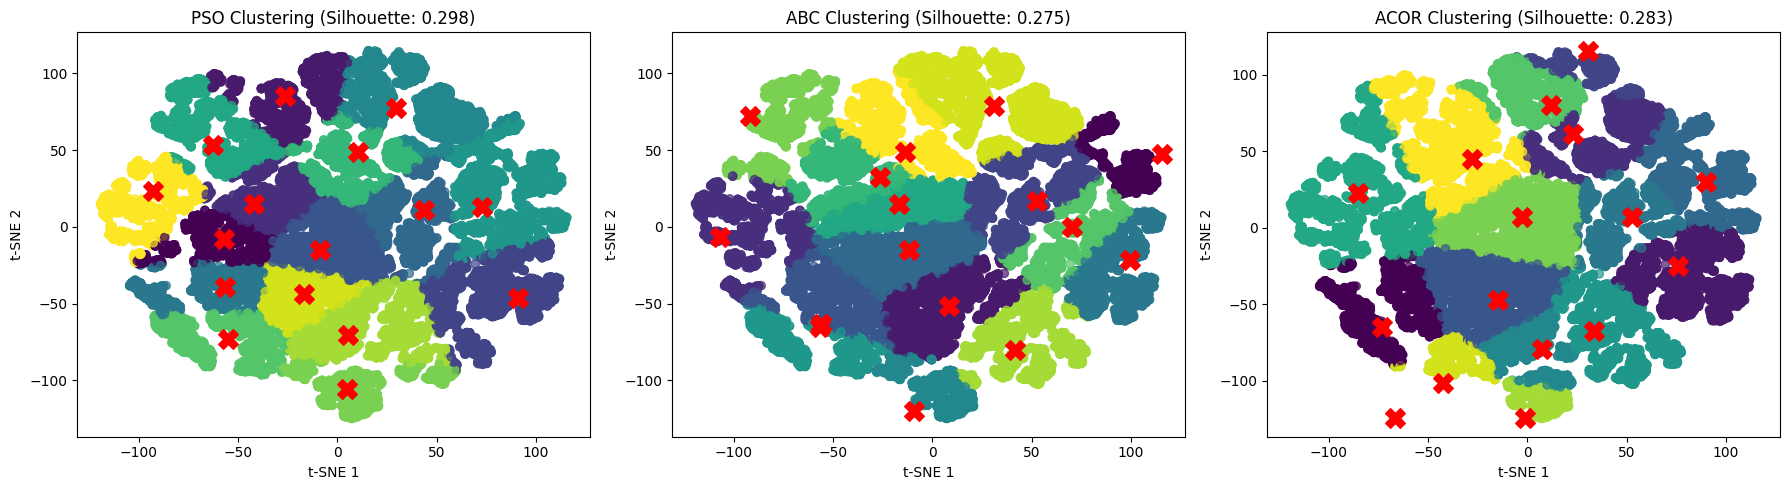

Clustering Comparison Results:
PSO: Cost = 32227104.15, Silhouette Score = 0.298
ABC: Cost = 36991223.65, Silhouette Score = 0.275
ACOR: Cost = 37296854.20, Silhouette Score = 0.283


In [15]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.scatter(tsne_crops[:, 0], tsne_crops[:, 1], c=pso_labels, cmap='viridis', alpha=0.7)
plt.scatter(pso_centers[:, 0], pso_centers[:, 1], c='red', s=200, marker='X')
plt.title("PSO Clustering (Silhouette: {:.3f})".format(pso_sil))
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

plt.subplot(1, 3, 2)
plt.scatter(tsne_crops[:, 0], tsne_crops[:, 1], c=abc_labels, cmap='viridis', alpha=0.7)
plt.scatter(abc_centers[:, 0], abc_centers[:, 1], c='red', s=200, marker='X')
plt.title("ABC Clustering (Silhouette: {:.3f})".format(abc_sil))
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

plt.subplot(1, 3, 3)
plt.scatter(tsne_crops[:, 0], tsne_crops[:, 1], c=acor_labels, cmap='viridis', alpha=0.7)
plt.scatter(acor_centers[:, 0], acor_centers[:, 1], c='red', s=200, marker='X')
plt.title("ACOR Clustering (Silhouette: {:.3f})".format(acor_sil))
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

plt.tight_layout()
plt.show()

# -------------------------------
# 7. Print Comparison Summary
# -------------------------------
print("Clustering Comparison Results:")
for algo, res in results.items():
    print(f"{algo}: Cost = {res['cost']:.2f}, Silhouette Score = {res['silhouette']:.3f}")